In [ ]:
# Barron functions:
## Linear functions f(x) = a^Tx + b
## Radial Basis Functions (RBF) f(x) = exp(-gamma * ||x - c||^2)
## Trigonomial functions f(x) = cos(ax) and sin(ax)

In [2]:
import numpy as np
import ot

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

In [3]:
from src.function_distrib import FunctionDistrib

n = 100
d = 3
l = 3

linear_functions = FunctionDistrib(n, d, l, function_type="linear")

linear_functions.Z.shape, linear_functions.Y.shape

((100, 3), (100, 1))

In [17]:
from src.trainer import Trainer

config = {
    "function_distrib":{
        "n": 100,
        "d": 4,
        "l": 13,
        "function_type": "rbf",
        "prior": "gaussian",
        "seed": 0
    },

    "model": {
        # "input_size": # infer
        # "output_size": # infer
        "hidden_size": 40,
        "n_hidden_layers": 3
    },

    "optimizer": {
        "lr": 0.001,
    },

    "epochs": 300
}

trainer = Trainer(config)
losses, w2_distances = trainer.train()

Epoch: 0, loss: 0.8070098757743835
Epoch: 100, loss: 0.010653971694409847
Epoch: 200, loss: 0.0005236799479462206


In [21]:
hidden_sizes = [5, 10, 20, 50, 100, 200, 500]
ls = [1, 2, 3, 10, 15]

losses = np.zeros((len(hidden_sizes), len(ls)))
w2_distances = np.zeros((len(hidden_sizes), len(ls)))

for i, hidden_size in enumerate(hidden_sizes):
    for j, l in enumerate(ls):
        config["model"]["hidden_size"] = hidden_size
        config["function_distrib"]["l"] = l
        trainer = Trainer(config)
        loss, w2 = trainer.train(plot=False)
        losses[i, j] = loss[-1]
        w2_distances[i, j] = w2[-1]

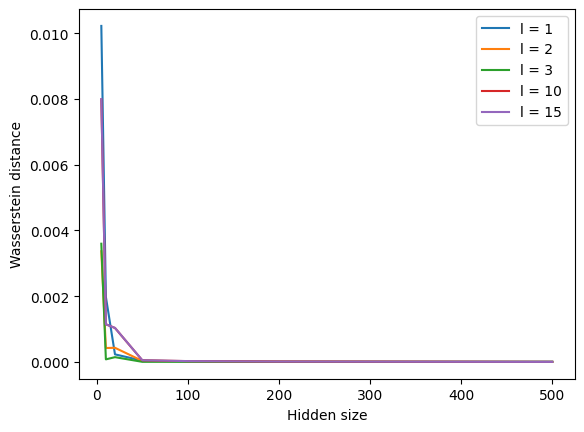

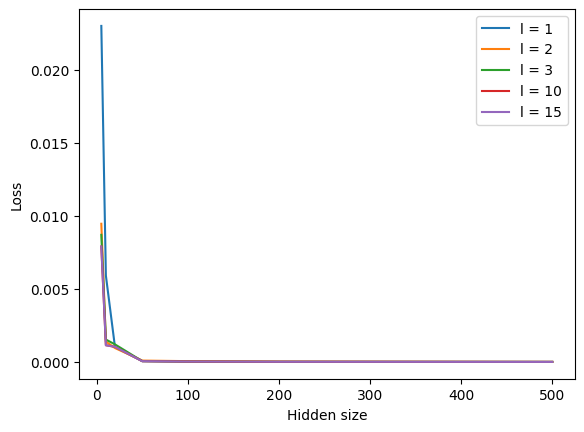

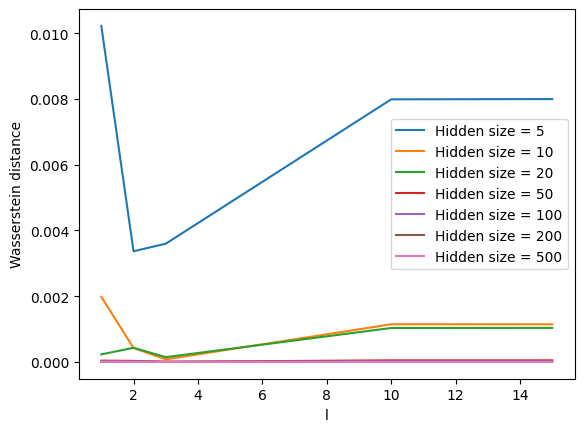

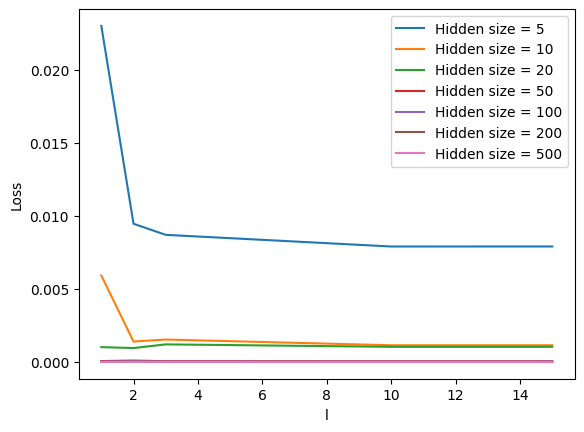

In [22]:
for i, l in enumerate(ls):
    plt.plot(hidden_sizes, w2_distances[:, i], label='l = {}'.format(l))
plt.ylabel('Wasserstein distance')
plt.xlabel('Hidden size')
plt.legend()
plt.show()

for i, l in enumerate(ls):
    plt.plot(hidden_sizes, losses[:, i], label='l = {}'.format(l))
plt.ylabel('Loss')
plt.xlabel('Hidden size')
plt.legend()
plt.show()

for i, hidden_size in enumerate(hidden_sizes):
    plt.plot(ls, w2_distances[i, :], label='Hidden size = {}'.format(hidden_size))
plt.ylabel('Wasserstein distance')
plt.xlabel('l')
plt.legend()
plt.show()

for i, hidden_size in enumerate(hidden_sizes):
    plt.plot(ls, losses[i, :], label='Hidden size = {}'.format(hidden_size))
plt.ylabel('Loss')
plt.xlabel('l')
plt.legend()